In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from google.colab import drive

In [125]:
%run /content/drive/MyDrive/Capstone/austin_sonoma_combined_utils.ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Capstone


<ipython-input-125-184c9cba245f>:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  austin_outcome['Outcome Date'] = pd.to_datetime(austin_outcome['DateTime'], errors='coerce')
<ipython-input-125-6399c308ebb2>:48: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df =  pd.read_csv(name)


Unnamed: 0 is NOT A STRING
Intake Date is NOT A STRING
Count is NOT A STRING
Outcome Date is NOT A STRING
Days in Shelter is NOT A STRING
Date Of Birth is NOT A STRING
replace null values in Name with 'Unknown'
replace null values in Outcome_Subtype with 'Unknown'


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [126]:
'''
params options

na_data will fill missing data with 'unknown', delete missing data or do nothing
input options are...
    * 'fill'
    * 'drop'
    * False

drop_outlier_days removes pets who have a lenght of stay exceeding the value YOU enter
input options are...
    * False
    * or any integer

embed creates 50x1 embedding vectors for color and breed.
    download https://nlp.stanford.edu/data/glove.6B.zip, unzip and save in repo
    * True
    * False

sample_dict controls stratified sampling
    * stratify_col: a column name used for stratified sampling... spelling and caps must be exact
    * train_size: a fraction of data you want for the training data
    * validate_size: a fraction of data you want for the validate data
    * test_size: a fraction of data you want for the test data

num_buckets how many buckets to break up length of stay into for model training
    creates new column Days_in_Shelter_Label
    * input is a integer
'''

params = {
        'na_data': 'fill',
        'drop_outlier_days': 300,
        'embed':True,
        'num_buckets':5,
        'sample_dict':
            {
            'stratify_col':'Type',
            'train_size':0.6, 'validate_size':0.2, 'test_size':0.2
            }
        }
train_df, validate_df, test_df = load_df(params)
df = pd.concat([train_df, validate_df, test_df], ignore_index=True) # do this if you want to look at all the data still

<ipython-input-125-6399c308ebb2>:48: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df =  pd.read_csv(name)


Unnamed: 0 is NOT A STRING
Intake Date is NOT A STRING
Count is NOT A STRING
Outcome Date is NOT A STRING
Days in Shelter is NOT A STRING
Date Of Birth is NOT A STRING
replace null values in Name with 'Unknown'
replace null values in Outcome_Subtype with 'Unknown'


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [127]:
df.columns

Index(['Unnamed:_0', 'Name', 'Type', 'Breed', 'Color', 'Sex', 'Intake_Date',
       'Animal_ID', 'Intake_Condition', 'Date_of_Birth', 'Outcome_Date',
       'Outcome_Type', 'Outcome_Subtype', 'Days_in_Shelter', 'Source',
       'Date_Of_Birth', 'Multiple_Visit_Count', 'Age_inDays_at_Outcome',
       'Age_Group', 'Is_Aggressive', 'Has_Name', 'Is_Fixed', 'Is_Mixed_Breed',
       'Is_Multicolor', 'Color_Embedding', 'Color_Embedding_Cluster',
       'Breed_Embedding', 'Breed_Embedding_Cluster', 'Days_in_Shelter_Label'],
      dtype='object')

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192707 entries, 0 to 192706
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Unnamed:_0               192707 non-null  int64         
 1   Name                     192707 non-null  object        
 2   Type                     192707 non-null  object        
 3   Breed                    192707 non-null  object        
 4   Color                    192707 non-null  object        
 5   Sex                      192707 non-null  object        
 6   Intake_Date              192707 non-null  datetime64[ns]
 7   Animal_ID                192707 non-null  object        
 8   Intake_Condition         192707 non-null  object        
 9   Date_of_Birth            192707 non-null  object        
 10  Outcome_Date             192707 non-null  datetime64[ns]
 11  Outcome_Type             192707 non-null  object        
 12  Outcome_Subtype 

In [129]:
df.describe()

,Unnamed:_0,Intake_Date,Outcome_Date,Days_in_Shelter,Date_Of_Birth,Multiple_Visit_Count,Age_inDays_at_Outcome,Is_Aggressive,Has_Name,Is_Fixed,Is_Mixed_Breed,Is_Multicolor,Color_Embedding_Cluster,Breed_Embedding_Cluster
count,192707.000000,192707,192707,192707.000000,192707,192707.000000,192707.000000,192707.000000,192707.000000,192707.000000,192707.000000,192707.000000,192707.000000,192707.000000
mean,103320.629552,2018-07-13 19:05:40.080536576,2018-06-25 17:44:52.914839808,-18.448961,2014-07-30 21:08:42.494771968,6.965824,1425.245326,0.004551,0.766184,0.364984,0.750315,0.567831,1.998054,1.908426
min,0.000000,2013-10-01 07:51:00,2013-10-01 10:39:00,-3660.000000,1900-01-01 00:00:00,1.000000,-1548.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50152.500000,2016-01-30 13:41:00,2015-12-26 13:52:00,0.000000,2013-09-30 00:00:00,1.000000,103.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,103236.000000,2018-05-04 15:37:00,2018-03-22 18:08:00,5.000000,2016-03-31 00:00:00,1.000000,390.000000,0.000000,1.000000,0.000000,1.000000,1.000000,3.000000,2.000000
75%,156466.500000,2020-10-05 08:58:30,2020-09-14 09:45:00,22.000000,2019-03-13 00:00:00,4.000000,1098.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000
max,210076.000000,2024-06-09 09:08:00,2024-06-09 14:52:00,299.000000,2024-06-05 00:00:00,776.000000,45426.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000
std,61269.767774,NaN,NaN,214.716535,NaN,49.618930,5195.123969,0.067307,0.423258,0.481427,0.432832,0.495379,1.474863,1.420458


Source
AUSTIN    Axes(0.125,0.11;0.775x0.77)
SONOMA    Axes(0.125,0.11;0.775x0.77)
Name: Days_in_Shelter, dtype: object

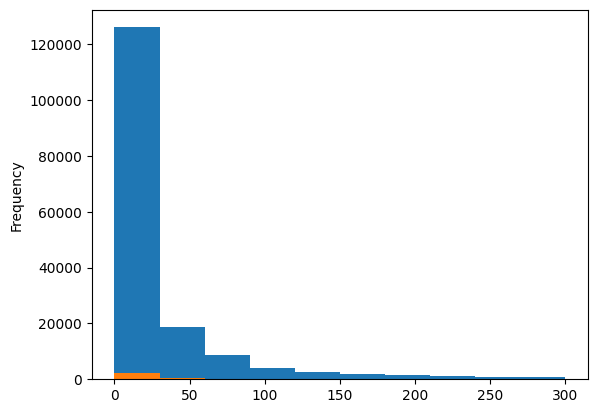

In [130]:
df.groupby('Source').Days_in_Shelter.plot.hist(range=[0, 300])

In [131]:
df.groupby('Source').Sex.unique()

Source
AUSTIN    [FEMALE, MALE, UNKNOWN]
SONOMA    [FEMALE, MALE, UNKNOWN]
Name: Sex, dtype: object

In [132]:
print(f'there are {len(df.Breed.unique())} unique breeds')
cat_breed_count = len(df.Breed[df.Type=='CAT'].unique())
print(f'cat breeds: {cat_breed_count}')
dog_breed_count = len(df.Breed[df.Type=='DOG'].unique())
print(f'dog breeds: {dog_breed_count}')

there are 2923 unique breeds
cat breeds: 118
dog breeds: 2805


In [133]:
df.groupby('Source').Type.value_counts()


Source  Type
AUSTIN  DOG     121155
        CAT      68831
SONOMA  DOG       1753
        CAT        968
Name: count, dtype: int64

Text(0.5, 1.0, 'CAT Breeds')

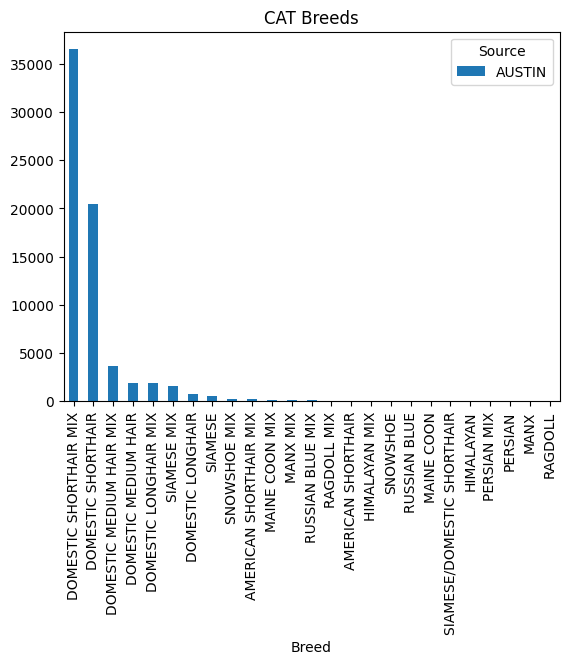

In [134]:
df[df.Type=='CAT'].groupby('Source').Breed.value_counts()[0:25].unstack(0).plot.bar()
plt.title('CAT Breeds')

Text(0.5, 1.0, 'DOG Breeds')

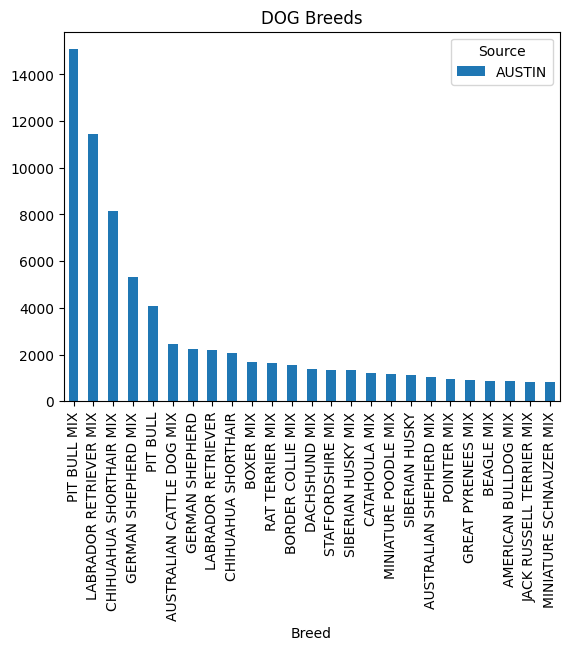

In [135]:
df[df.Type=='DOG'].groupby('Source').Breed.value_counts()[0:25].unstack(0).plot.bar()
plt.title('DOG Breeds')

Additional cleaning to remove BIRD and LIVESTOCK animal types is needed (Applied: 06/24/2024)

In [136]:
df.Type.unique()


array(['DOG', 'CAT'], dtype=object)

In [137]:
print(f'there are {len(df.Color.unique())} unique colors')
breed_color = len(df.Color[df.Type=='CAT'].unique())
print(f'cat colors: {breed_color}')
breed_color = len(df.Color[df.Type=='DOG'].unique())
print(f'dog colors: {breed_color}')
print()
print(df.Color.value_counts())

there are 657 unique colors
cat colors: 348
dog colors: 412

Color
BLACK/WHITE                21345
BLACK                      15118
BROWN TABBY                10454
BROWN/WHITE                 7134
WHITE                       7008
                           ...  
SILVER TABBY/BLACK             1
RED MERLE/RED TICK             1
SILVER LYNX POINT/WHITE        1
BLACK/SILVER TABBY             1
RED TICK/BROWN MERLE           1
Name: count, Length: 657, dtype: int64


Text(0.5, 1.0, 'DOG colors')

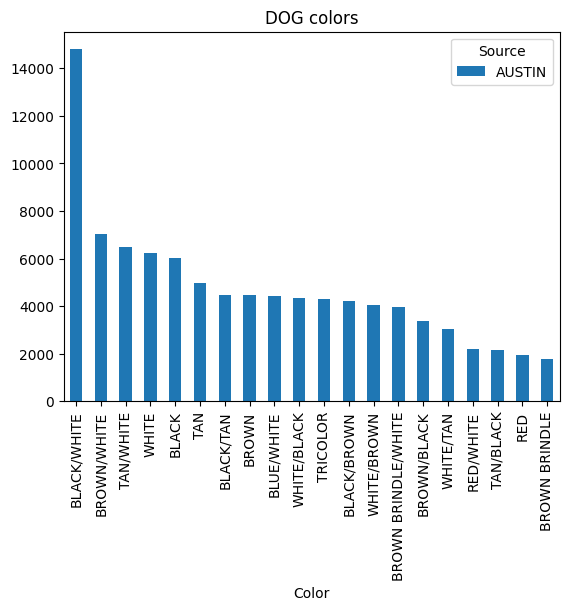

In [138]:
df[df.Type=='DOG'].groupby('Source').Color.value_counts()[:20].unstack(0).plot.bar()
plt.title('DOG colors')

Text(0.5, 1.0, 'cat colors')

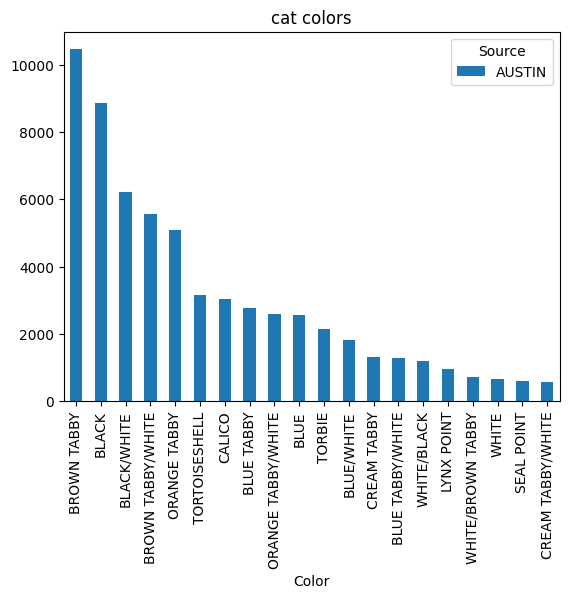

In [139]:
df[df.Type=='CAT'].groupby('Source').Color.value_counts()[:20].unstack(0).plot.bar()
plt.title('cat colors')

Text(0.5, 1.0, 'intake type')

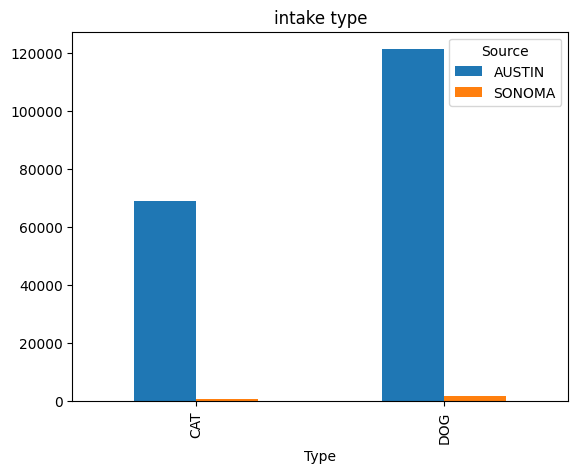

In [140]:
df.groupby('Source').Type.value_counts().unstack(0).plot.bar()
plt.title('intake type')

Further cleaning would be beneficial for outcome type:


*   Relocate = Transfer
*   RTO-Adopt = RTOS
*   Missing = Lost = Stolen
*   Euthanasia = Euthanize
*   Vet = Unknown
*   Dead = Disposal

Applied 06/24/2024

Text(0.5, 1.0, 'Outcome type')

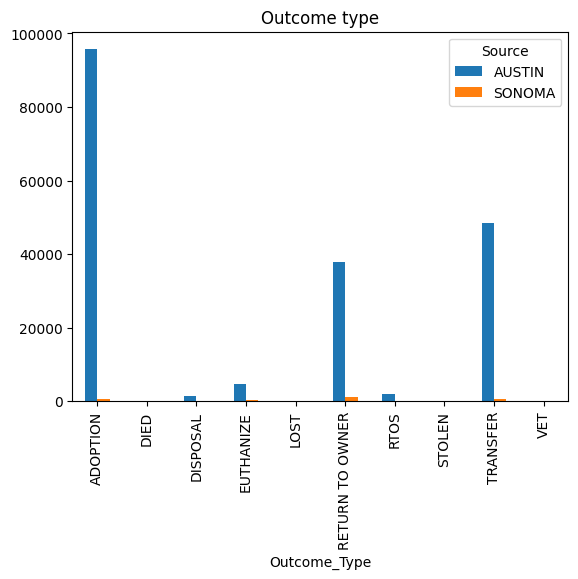

In [141]:
df.groupby('Source').Outcome_Type.value_counts().unstack(0).plot.bar()
plt.title('Outcome type')

In [142]:
len(df.Outcome_Subtype.unique())

125

Most Outcome subtype is unknown. Could combine similar categories

Text(0.5, 1.0, 'Outcome subtype')

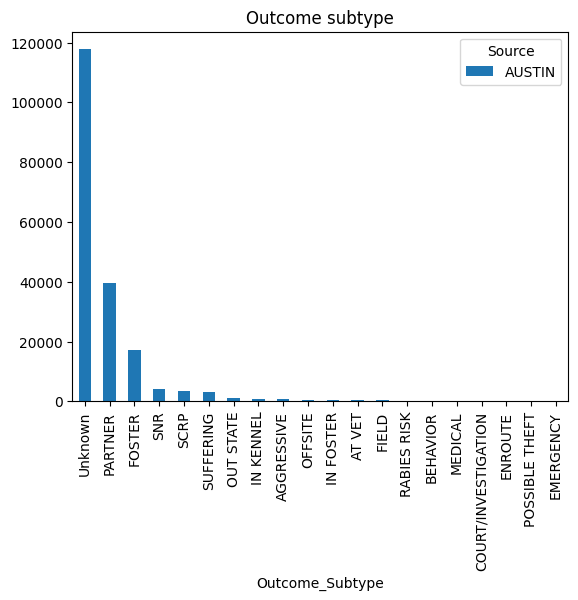

In [143]:
df.groupby('Source').Outcome_Subtype.value_counts()[:20].unstack(0).plot.bar()
plt.title('Outcome subtype')

Most intake condition = Healthy or Treatable

Text(0.5, 1.0, 'Intake_Condition')

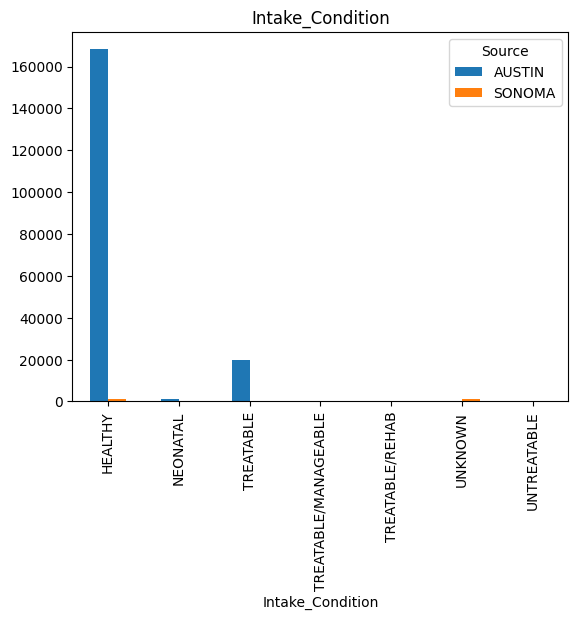

In [144]:
df.groupby('Source').Intake_Condition.value_counts()[:20].unstack(0).plot.bar()
plt.title('Intake_Condition')

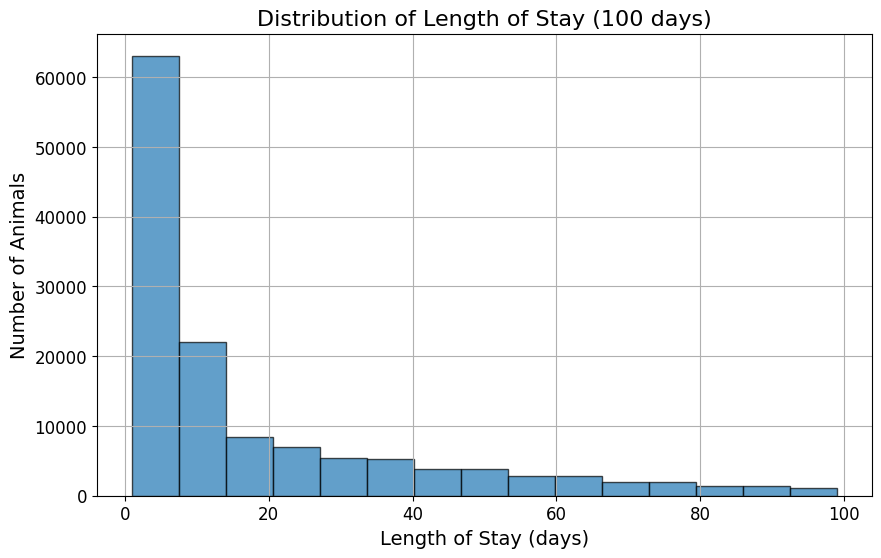

In [145]:
# Plot the length of stay
plt.figure(figsize=(10, 6))
plt.hist(df[(df.Days_in_Shelter<100) & (df.Days_in_Shelter>0)]['Days_in_Shelter'], bins=15, edgecolor='k', alpha=0.7)
plt.title('Distribution of Length of Stay (100 days)', fontsize=16)
plt.xlabel('Length of Stay (days)', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

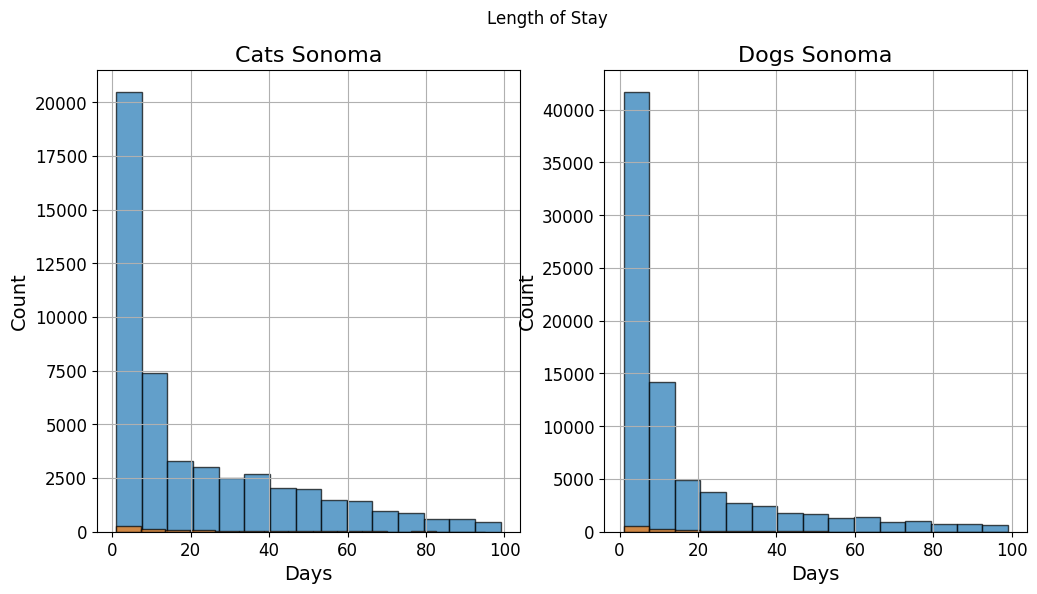

In [179]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs by source
cats_a = df[(df['Type'] == 'CAT') & (df['Source'] == 'AUSTIN')]
dogs_a = df[(df['Type'] == 'DOG') & (df['Source'] == 'AUSTIN')]
cats_s = df[(df['Type'] == 'CAT') & (df['Source'] == 'SONOMA')]
dogs_s = df[(df['Type'] == 'DOG') & (df['Source'] == 'SONOMA')]

# Plot the log-transformed length of stay for cats austin
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=12)

plt.subplot(1, 2, 1)
plt.hist(cats_a[(cats_a.Days_in_Shelter<100) & (cats_a.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Cats Austin', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for cats sonoma
plt.subplot(1, 2, 1)
plt.hist(cats_s[(cats_s.Days_in_Shelter<100) & (cats_s.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Cats Sonoma', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs austin
plt.subplot(1, 2, 2)
plt.hist(dogs_a[(dogs_a.Days_in_Shelter<100) & (dogs_a.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Dogs Austin', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs sonoma
plt.subplot(1, 2, 2)
plt.hist(dogs_s[(dogs_s.Days_in_Shelter<100) & (dogs_s.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Dogs Sonoma', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

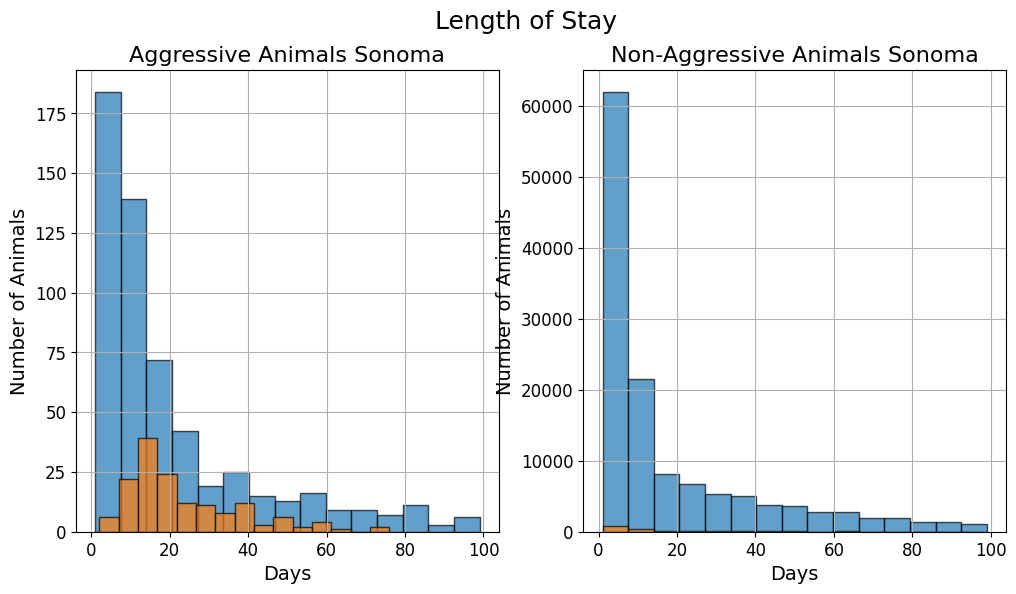

In [181]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
aggressive_a = df[(df['Is_Aggressive'] == 1) & (df['Source'] == 'AUSTIN')]
aggressive_s = df[(df['Is_Aggressive'] == 1) & (df['Source'] == 'SONOMA')]
not_aggressive_a = df[(df['Is_Aggressive'] == 0) & (df['Source'] == 'AUSTIN')]
not_aggressive_s = df[(df['Is_Aggressive'] == 0) & (df['Source'] == 'SONOMA')]

# Plot the log-transformed length of stay for cats austin
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=18)

plt.subplot(1, 2, 1)
plt.hist(aggressive_a[(aggressive_a.Days_in_Shelter<100) & (aggressive_a.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Aggressive Animals Austin', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for cats sonoma
plt.subplot(1, 2, 1)
plt.hist(aggressive_s[(aggressive_s.Days_in_Shelter<100) & (aggressive_s.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Aggressive Animals Sonoma', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs austin
plt.subplot(1, 2, 2)
plt.hist(not_aggressive_a[(not_aggressive_a.Days_in_Shelter<100) & (not_aggressive_a.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Non-Aggressive Animals Austin', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs sonoma
plt.subplot(1, 2, 2)
plt.hist(not_aggressive_s[(not_aggressive_s.Days_in_Shelter<100) & (not_aggressive_s.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Non-Aggressive Animals Sonoma', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


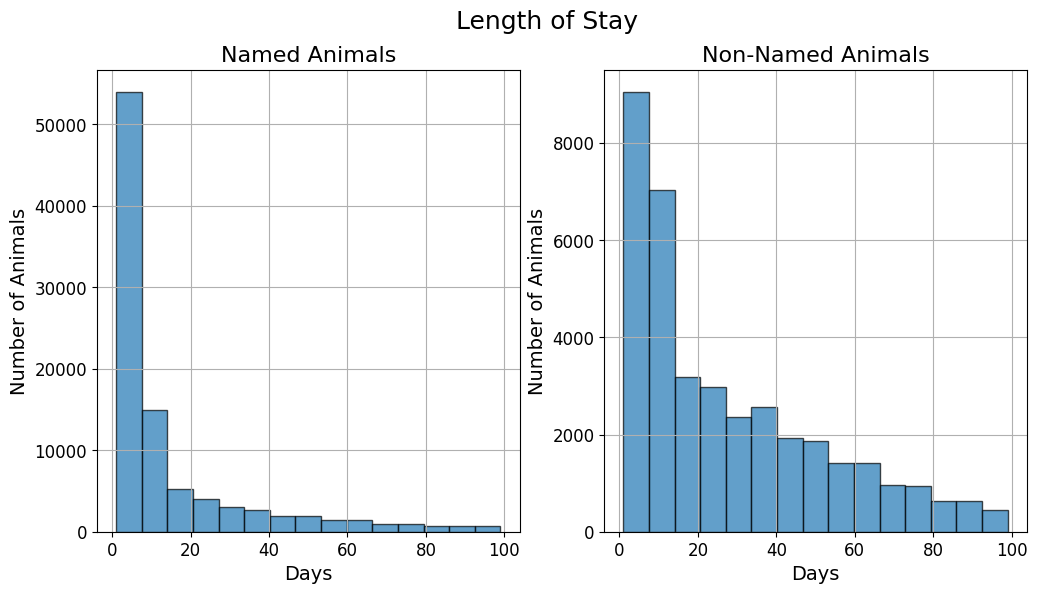

In [183]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
Named = df[df['Has_Name'] == 1]
not_Named = df[df['Has_Name'] == 0]

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=18)
plt.subplot(1, 2, 1)
plt.hist(Named[(Named.Days_in_Shelter<100) & (Named.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Named Animals', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs austin
plt.subplot(1, 2, 2)
plt.hist(not_Named[(not_Named.Days_in_Shelter<100) & (not_Named.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Non-Named Animals', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

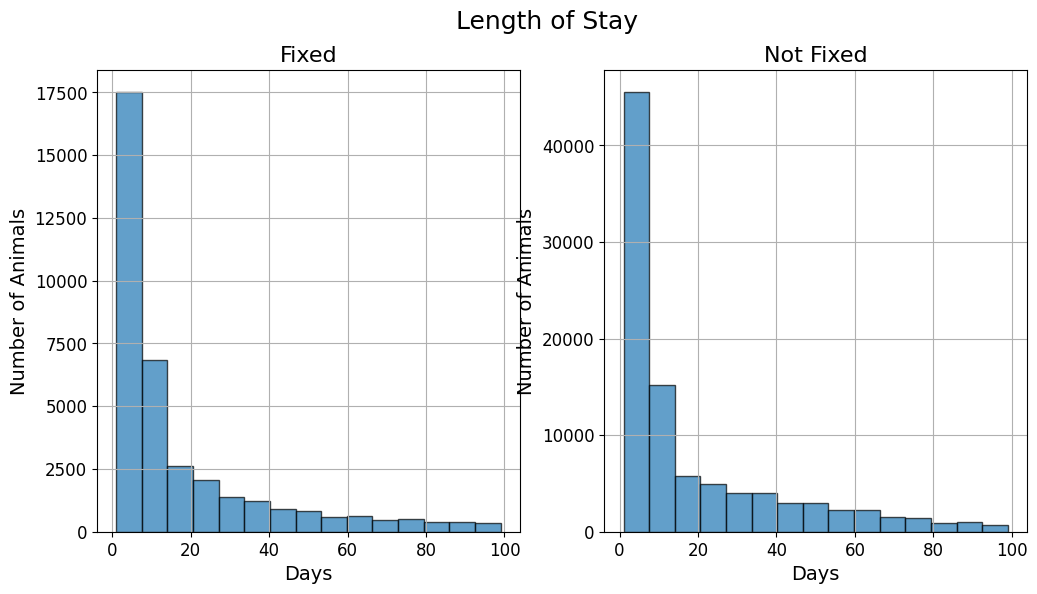

In [149]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
positive = df[df['Is_Fixed'] == 1]
negative = df[df['Is_Fixed'] == 0]

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=18)

plt.subplot(1, 2, 1)
plt.hist(positive[(positive.Days_in_Shelter<100) & (positive.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Fixed', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs
plt.subplot(1, 2, 2)
plt.hist(negative[(negative.Days_in_Shelter<100) & (negative.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Not Fixed', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

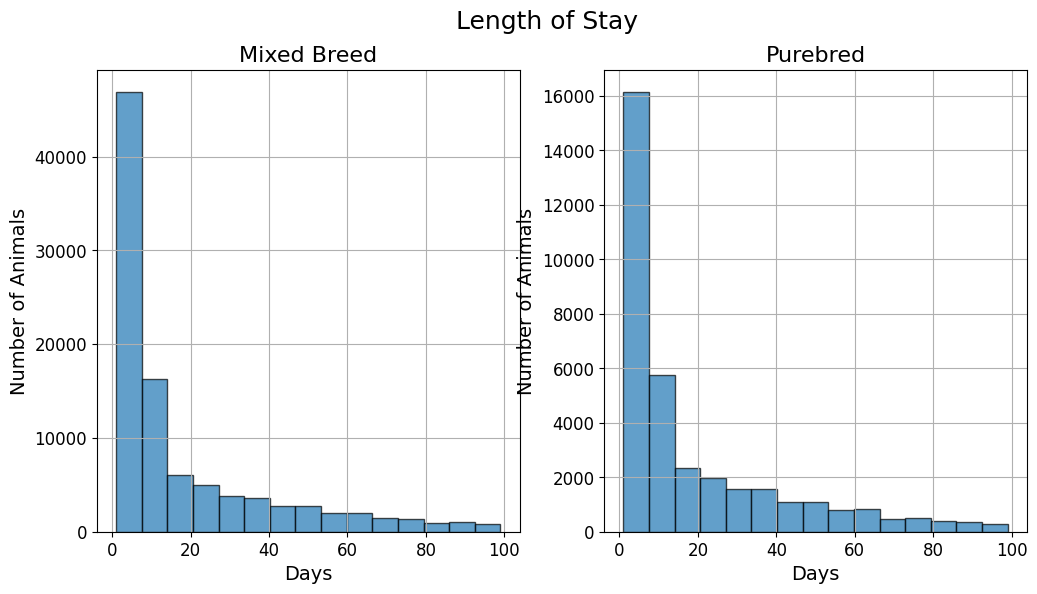

In [150]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
positive = df[df['Is_Mixed_Breed'] == 1]
negative = df[df['Is_Mixed_Breed'] == 0]

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=18)

plt.subplot(1, 2, 1)
plt.hist(positive[(positive.Days_in_Shelter<100) & (positive.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Mixed Breed', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs
plt.subplot(1, 2, 2)
plt.hist(negative[(negative.Days_in_Shelter<100) & (negative.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Purebred', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

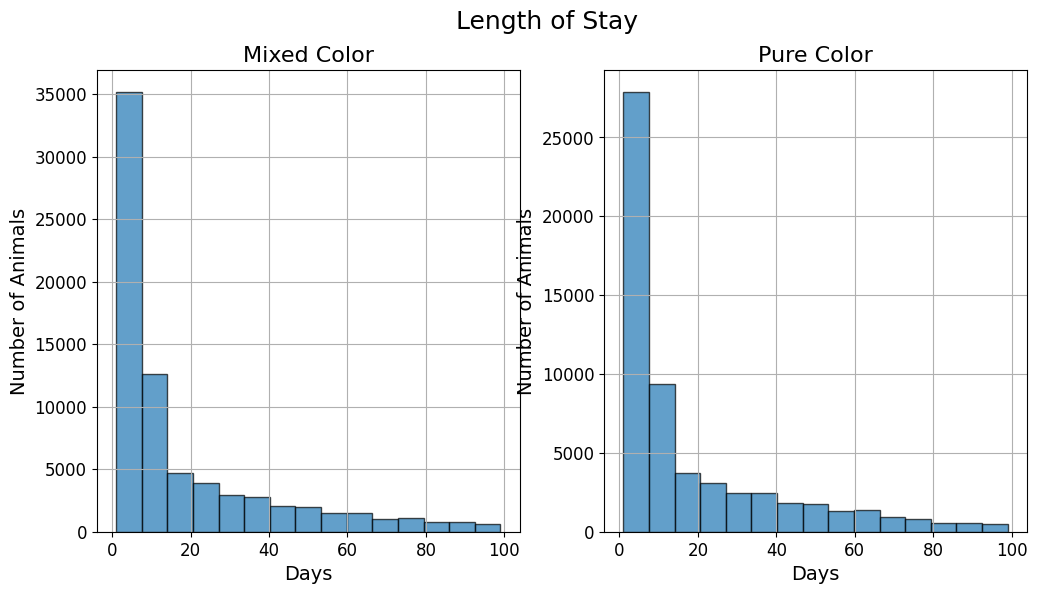

In [151]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
positive = df[df['Is_Multicolor'] == 1]
negative = df[df['Is_Multicolor'] == 0]

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=18)

plt.subplot(1, 2, 1)
plt.hist(positive[(positive.Days_in_Shelter<100) & (positive.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Mixed Color', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs
plt.subplot(1, 2, 2)
plt.hist(negative[(negative.Days_in_Shelter<100) & (negative.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Pure Color', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

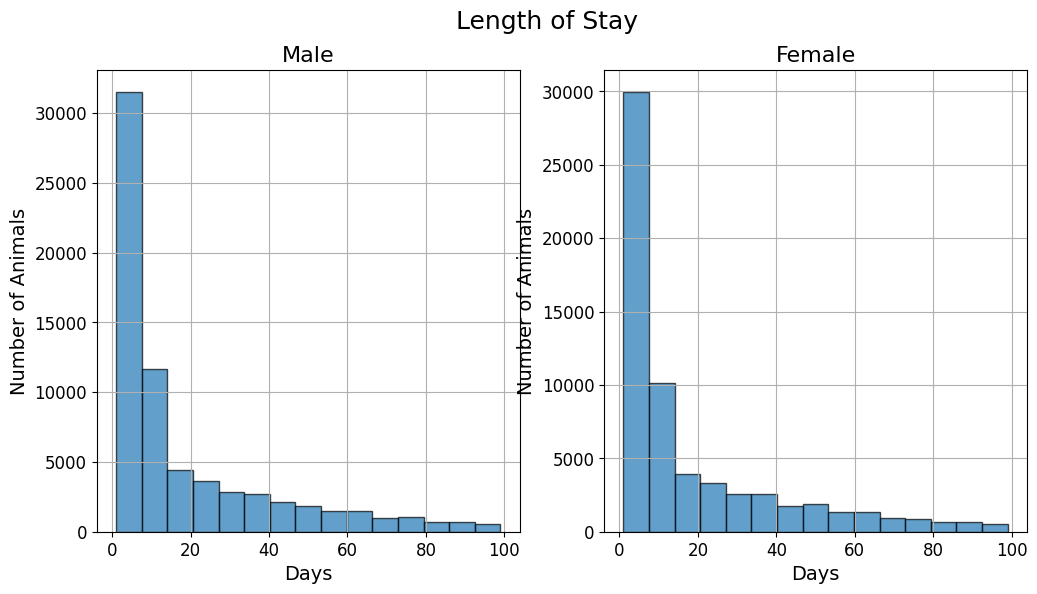

In [152]:
# Log transformation of the length of stay
df['Log Length of Stay'] = np.log1p(df['Days_in_Shelter'])  # log1p is used to handle log(0)

# Separate df for cats and dogs
Male = df[df['Sex'] == 'MALE']
Female = df[df['Sex'] == 'FEMALE']

# Plot the log-transformed length of stay for cats
plt.figure(figsize=(12, 6))
plt.suptitle('Length of Stay', fontsize=18)

plt.subplot(1, 2, 1)
plt.hist(Male[(Male.Days_in_Shelter<100) & (Male.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Male', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot the log-transformed length of stay for dogs
plt.subplot(1, 2, 2)
plt.hist(Female[(Female.Days_in_Shelter<100) & (Female.Days_in_Shelter>0)]['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Female', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Number of Animals', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

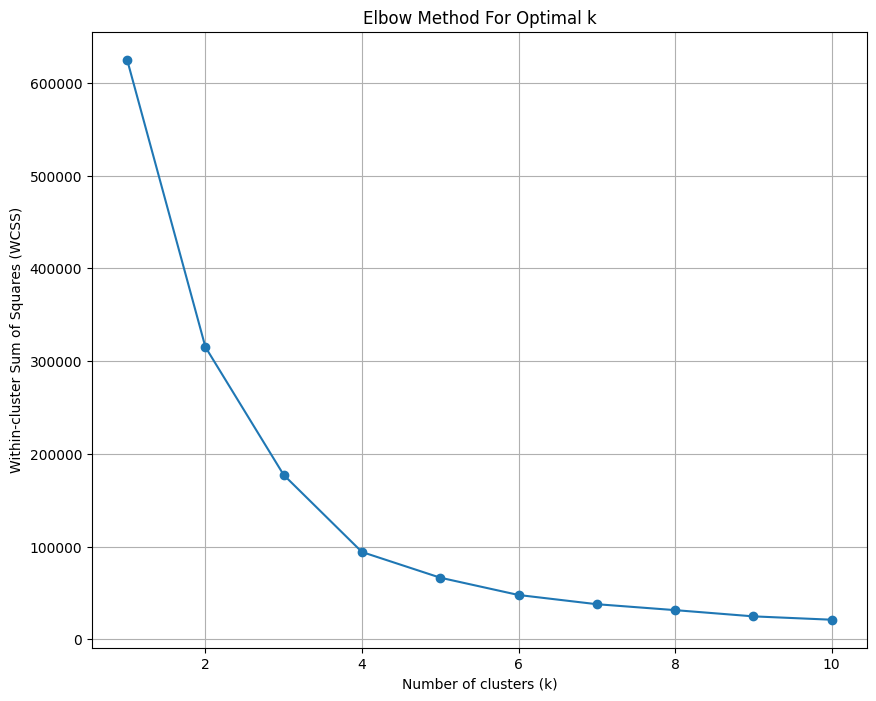

In [153]:
embeddings = np.array(df.Color_Embedding.tolist())

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Function to compute WCSS for different values of k
def compute_wcss(data):
    wcss = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Compute WCSS
wcss = compute_wcss(reduced_embeddings)

# Plot the elbow curve
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


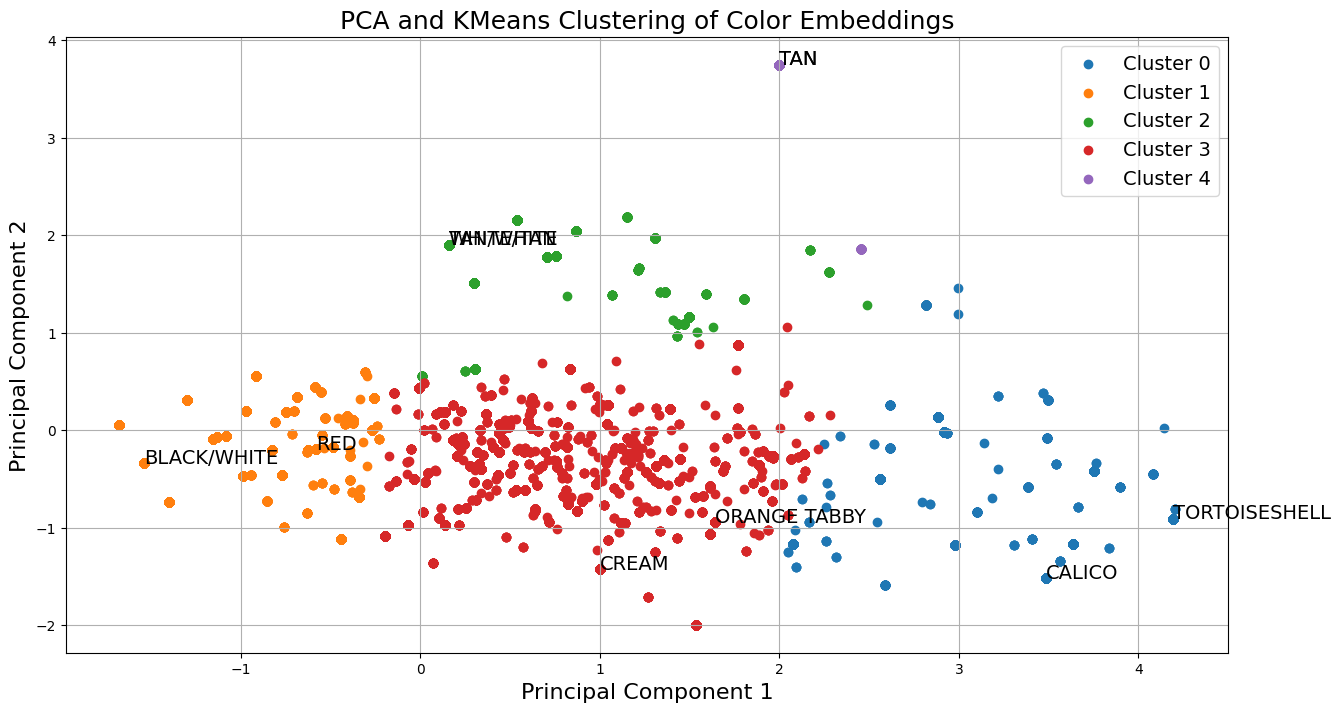

In [154]:
embeddings = np.array(df.Color_Embedding.tolist())

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Apply KMeans clustering
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Create a DataFrame for the reduced embeddings
df_embeddings = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
df_embeddings['Color'] = df.Color
df_embeddings['Cluster'] = clusters

# Plot the reduced embeddings
plt.figure(figsize=(15, 8))
# plt.scatter(df_embeddings['PC1'], df_embeddings['PC2'])
# Use a different color for each cluster
for cluster in range(n_clusters):
    clustered_points = df_embeddings[df_embeddings['Cluster'] == cluster]
    plt.scatter(clustered_points['PC1'], clustered_points['PC2'], label=f'Cluster {cluster}')
    for i, color in clustered_points.sample(2).iterrows():
        plt.annotate(color['Color'], (color['PC1'], color['PC2']), fontsize=14)

plt.title('PCA and KMeans Clustering of Color Embeddings', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

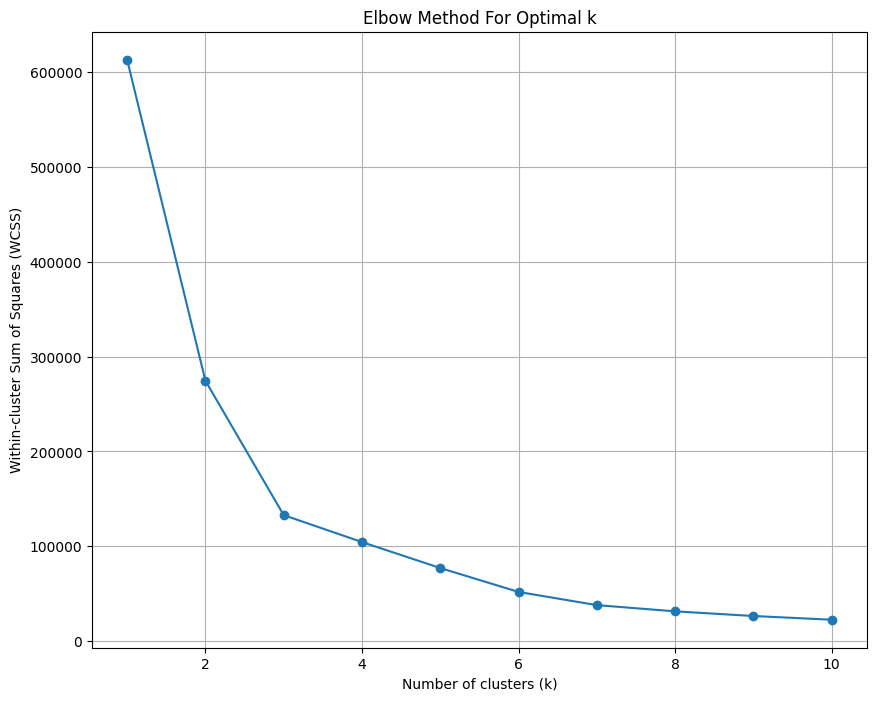

In [155]:
embeddings = np.array(df.Breed_Embedding.tolist())

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Function to compute WCSS for different values of k
def compute_wcss(data):
    wcss = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Compute WCSS
wcss = compute_wcss(reduced_embeddings)

# Plot the elbow curve
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


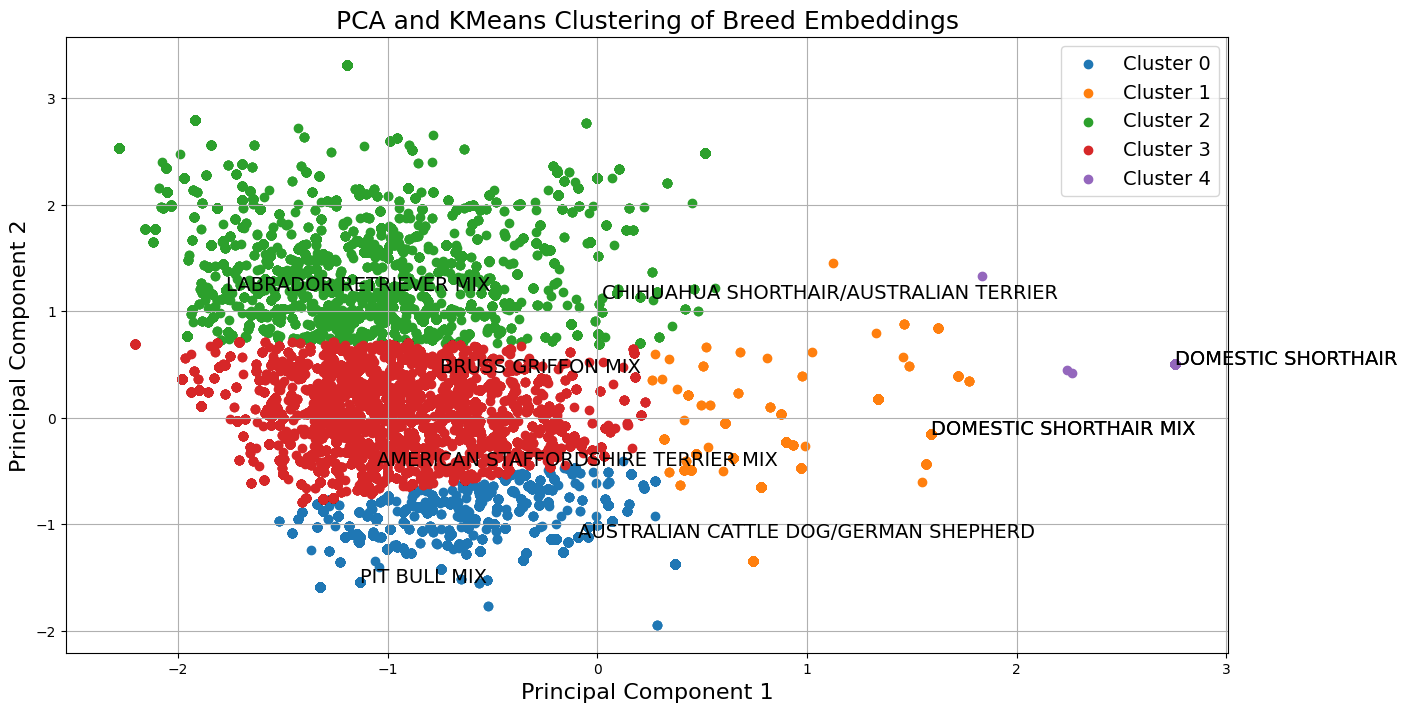

In [156]:
embeddings = np.array(df.Breed_Embedding.tolist())

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Apply KMeans clustering
n_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Create a DataFrame for the reduced embeddings
df_embeddings = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
df_embeddings['Breed'] = df.Breed
df_embeddings['Cluster'] = clusters

# Plot the reduced embeddings
plt.figure(figsize=(15, 8))
# plt.scatter(df_embeddings['PC1'], df_embeddings['PC2'])
# Use a different color for each cluster
for cluster in range(n_clusters):
    clustered_points = df_embeddings[df_embeddings['Cluster'] == cluster]
    plt.scatter(clustered_points['PC1'], clustered_points['PC2'], label=f'Cluster {cluster}')
    for i, breed in clustered_points.sample(2).iterrows():
        plt.annotate(breed['Breed'], (breed['PC1'], breed['PC2']), fontsize=14)

plt.title('PCA and KMeans Clustering of Breed Embeddings', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=16)
plt.ylabel('Principal Component 2', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()